# Sheet 10

## Task 1 - CIFAR10 Dataset


In [18]:
import torch
from torchvision import datasets, transforms
from torch import nn, optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

print(torch.__version__)
print(torch.backends.mps.is_built())  # Should return True
print(torch.backends.mps.is_available())  # Should return True

# Check if MPS is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS")
else:
    device = torch.device("cpu")
    print("MPS device not found, using CPU")



2.5.1
True
True
Using MPS


In [19]:


transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip some images horizontally
    transforms.RandomCrop(32, padding=4),  # Randomly crop with padding
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # Normalize with mean and std
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=50, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=50, shuffle=False)

# Calculate sizes of training and test sets
train_size = len(train_dataset)
test_size = len(test_dataset)

# Calculate and print ratio
ratio = train_size / test_size
print(f"The training set is {ratio}x larger than the test set")
print(f"Training set size: {train_size}")
print(f"Test set size: {test_size}")

# Get the first 5 images and their labels from the training set
images, labels = next(iter(train_loader))  # Get first batch
print(labels[:5])  # Print first 5 labels
# Now get the label names
classes = train_dataset.classes
print(classes[:5])


Files already downloaded and verified
Files already downloaded and verified
The training set is 5.0x larger than the test set
Training set size: 50000
Test set size: 10000
tensor([0, 7, 7, 5, 1])
['airplane', 'automobile', 'bird', 'cat', 'deer']


In [20]:
input_size = 1024
hidden_sizes = [256, 64]
output_size = 10

# using nn.Sequential
model = nn.Sequential(nn.Linear(3*input_size, hidden_sizes[0]),
                     nn.ReLU(),
                     nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                     nn.ReLU(),
                     nn.Linear(hidden_sizes[1], output_size),
                     nn.LogSoftmax(dim=1)).to(device)

# general way of setting up a model
class Dense(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3*input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], 10)
        self.to(device)

    def forward(self,x):
        x = x.to(device)
        batch_size = x.shape[0]
        x = x.reshape(batch_size, -1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        # Convert output into a categorical probability distribution
        x = nn.functional.log_softmax(self.fc3(x), dim=1)
        return x
    
    def count_parameters(self):
        total_params = 0
        for param in self.parameters():
            total_params += param.numel()
        return total_params
    
    def get_accuracy(self, test_loader):
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return correct / total
    
    def train(self, train_loader, epochs=5, lr=0.001):
        criterion = nn.NLLLoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)
        for epoch in range(epochs):
            pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
            for images, labels in pbar:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                output = self(images)
                loss = criterion(output, labels)
                loss.backward()
                optimizer.step()
                pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
model = Dense()
print(f"Number of parameters in the model: {model.count_parameters()}")

model.train(train_loader, epochs=10, lr=0.001)

print(f"Accuracy on the test set: {np.round(model.get_accuracy(test_loader), 2)}")


Number of parameters in the model: 803786


Epoch 10/10: 100%|██████████| 1000/1000 [00:07<00:00, 125.88it/s, loss=1.2670]


Accuracy on the test set: 0.47


In [21]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=1).to(device)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1).to(device)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 64).to(device)
        self.fc2 = nn.Linear(64, 10).to(device)  # 10 classes for CIFAR-10

    def count_parameters(self):
        total_params = 0
        for param in self.parameters():
            total_params += param.numel()
        return total_params
        
    def forward(self, x):
        x = nn.functional.silu(self.conv1(x))
        x = self.pool1(x)
        x = nn.functional.silu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 64 * 7 * 7)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        
    def train_model(self, train_loader, epochs=10, lr=0.001):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)
        for epoch in range(epochs):
            pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
            for images, labels in pbar:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                output = self(images)
                loss = criterion(output, labels)
                loss.backward()
                optimizer.step()
                pbar.set_postfix({'loss': f'{loss.item():.4f}'})
                
    def get_accuracy(self, test_loader):
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return correct / total

model = CNN().to(device)
print(f"Number of parameters in the CNN: {model.count_parameters()}")
model.train_model(train_loader, epochs=10, lr=0.001)
print(f"Accuracy on the test set: {np.round(model.get_accuracy(test_loader), 2)}")


Number of parameters in the CNN: 222346


Epoch 10/10: 100%|██████████| 1000/1000 [00:10<00:00, 92.65it/s, loss=0.6377]


Accuracy on the test set: 0.73


### 1.7 Compare with SVC 

In [22]:
from sklearn.svm import SVC
# Convert training data to numpy arrays and take first 10k samples
X_train = []
y_train = []
for images, labels in train_loader:
    X_train.append(images.numpy().reshape(images.shape[0], -1))
    y_train.append(labels.numpy())
    if len(X_train) * images.shape[0] >= 10000:
        break
X_train = np.concatenate(X_train)[:10000]
y_train = np.concatenate(y_train)[:10000]

# Convert test data to numpy arrays
X_test = []
y_test = []
for images, labels in test_loader:
    X_test.append(images.numpy().reshape(images.shape[0], -1))
    y_test.append(labels.numpy())
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

# Train SVC classifier
svc = SVC(kernel='rbf')
print("Training SVC classifier...")
svc.fit(X_train, y_train)

# Test accuracy
accuracy = svc.score(X_test, y_test)
print(f"SVC Accuracy on the test set: {np.round(accuracy, 2)}")


Training SVC classifier...
SVC Accuracy on the test set: 0.39


In [23]:
# Get number of support vectors
n_support_vectors = svc.n_support_.sum()
print(f"Number of support vectors: {n_support_vectors}")
print(f"Percentage of training data used as support vectors: {n_support_vectors/len(X_train)*100:.1f}%")


Number of support vectors: 9743
Percentage of training data used as support vectors: 97.4%


## Task 2 - Learning Features


Logistic Regression Accuracy on the test set: 0.837


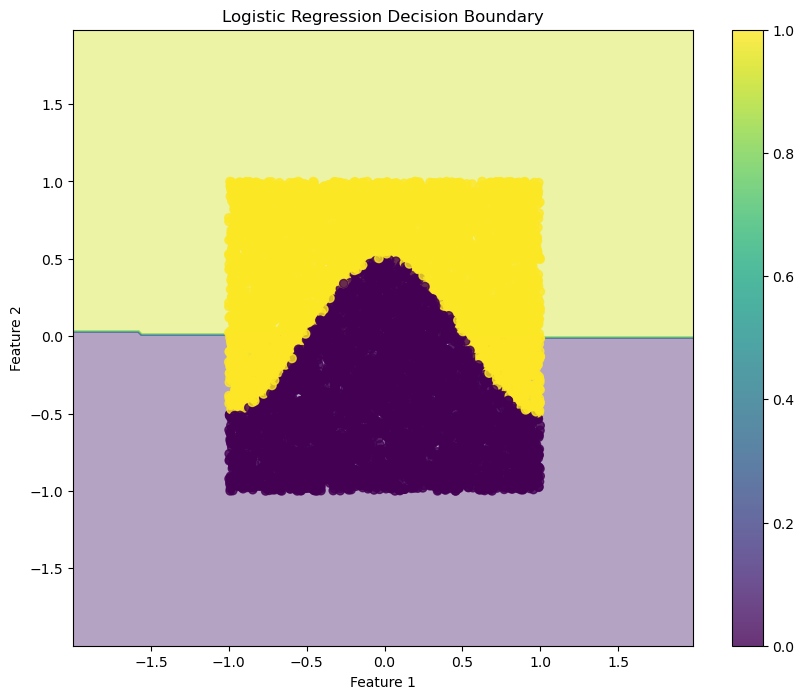

In [24]:
path = "/Users/yhra/Documents/Master/Semester_3/MLFMM/UE/10/PSet10_files"
# Load data
X = np.load(f'{path}/X_classification.npy')
y = np.load(f'{path}/y_classification.npy')

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Train logistic regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

# Test accuracy
accuracy = lr.score(X_test, y_test)
print(f"Logistic Regression Accuracy on the test set: {accuracy:.3f}")

# Create a mesh grid to visualize decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Get predictions for each point in the mesh
Z = lr.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary and scatter points
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Logistic Regression Decision Boundary')
plt.colorbar()
plt.show()


In [25]:
# Train models with different hidden dimensions
hidden_dims = [2, 3, 4, 5, 6, 7, 8, 9, 10]
accuracies = []

for hidden_dim in hidden_dims:
    # Initialize model, optimizer and loss function
    model = DeepClassifier(n_hidden=1, hidden_dim=hidden_dim)
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.NLLLoss()

    # Create datasets and dataloaders
    traindataset = CustomDataset(X_train, y_train)
    trainloader = torch.utils.data.DataLoader(traindataset,
                                            batch_size=64, shuffle=True)

    # Training loop
    n_epochs = 100
    for epoch in range(n_epochs):
        progress_bar = tqdm(trainloader, desc=f'Epoch {epoch+1}/{n_epochs}')
        total_loss = 0
        
        for batch_X, batch_y in progress_bar:
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update progress bar
            total_loss += loss.item()
            progress_bar.set_postfix({'loss': total_loss/len(trainloader)})

    # Calculate test accuracy
    testdataset = CustomDataset(X_test, y_test)
    testloader = torch.utils.data.DataLoader(testdataset, batch_size=64)

    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for X, y in testloader:
            outputs = model(X)
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

    accuracy = correct / total
    accuracies.append(accuracy)
    print(f"Hidden dim: {hidden_dim}, Test Accuracy: {accuracy:.3f}")

# Find minimum dimensions needed for 0.99 accuracy
for dim, acc in zip(hidden_dims, accuracies):
    if acc >= 0.99:
        print(f"\nMinimum hidden dimensions needed for 0.99 accuracy: {dim}")
        break
else:
    print("\nNo model achieved 0.99 accuracy")


Epoch 100/100: 100%|██████████| 79/79 [00:00<00:00, 1247.77it/s, loss=0.326]


Hidden dim: 2, Test Accuracy: 0.837


Epoch 100/100: 100%|██████████| 79/79 [00:00<00:00, 1433.37it/s, loss=0.051]


Hidden dim: 3, Test Accuracy: 0.985


Epoch 100/100: 100%|██████████| 79/79 [00:00<00:00, 1408.38it/s, loss=0.0592]


Hidden dim: 4, Test Accuracy: 0.983


Epoch 100/100: 100%|██████████| 79/79 [00:00<00:00, 1431.88it/s, loss=0.0565]


Hidden dim: 5, Test Accuracy: 0.984


Epoch 100/100: 100%|██████████| 79/79 [00:00<00:00, 1088.37it/s, loss=0.053]


Hidden dim: 6, Test Accuracy: 0.985


Epoch 100/100: 100%|██████████| 79/79 [00:00<00:00, 1246.75it/s, loss=0.0462]


Hidden dim: 7, Test Accuracy: 0.984


Epoch 100/100: 100%|██████████| 79/79 [00:00<00:00, 1400.26it/s, loss=0.0453]


Hidden dim: 8, Test Accuracy: 0.985


Epoch 100/100: 100%|██████████| 79/79 [00:00<00:00, 1411.68it/s, loss=0.0424]


Hidden dim: 9, Test Accuracy: 0.990


Epoch 100/100: 100%|██████████| 79/79 [00:00<00:00, 1405.44it/s, loss=0.0428]


Hidden dim: 10, Test Accuracy: 0.988

No model achieved 0.99 accuracy
